- Post processing library for HEADTAIL: https://gitlab.cern.ch/bi/headtail
    - Turorial: https://indico.cern.ch/event/931117/contributions/3913554/attachments/2096199/3523367/014_HeadtailMonitor.pdf 
    - wiki page: https://wikis.cern.ch/display/BEBI/BQHT
- Explanation on the Headtail monitor and when CC synchronised with the main RF: (slide 15-16: https://www.isis.stfc.ac.uk/Gallery/09%20-%20Graeme%20Burt_IOPPABG2019.pdf)

- Explanation on the headtail monitor analysis when the CC is not synchronised with the main RF (CC MD 2018) (slide 16):
https://indico.cern.ch/event/800428/attachments/1804664/2945632/CrabCavity_BE_Seminar.pdf 

"The Head-Tail Monitor gives two data sets. 
1. A **sigma (or sum)** signal which is the
longitudinal line density for a given window (often 10,000 turns). 
2. A **delta (or difference)** signal which is a
measure of the transverse offset within the bunch."

In [24]:
import glob
from headtail.modules import bqht
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
# Load h5 files from local storage

In [12]:
# Create a new instance ands set the system to SPS
ht = bqht.BQHT(system='SPS')
# Select a file to use
dataDir = './h5_files/'
files = sorted(glob.glob(dataDir+'/*.h5'))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
range(0, 2000)
2.3062e-05
2.3062e-05


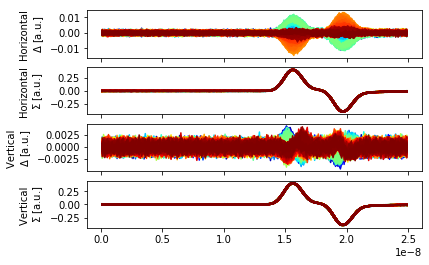

In [28]:
# from: https://wikis.cern.ch/display/BEBI/BQHT+data+processing+library
filename = files[0]
# Open the file using a context manager
with ht.open_file(filename) as htf:
    # First we need to locate which bunch slots contain bunches
    # In other words: Automatically locating bunches using the sum signals
    htf.locate_bunches()
 
    # The `bunches` parameter should now contain a list of occupied bunch slots
    # In other words: Provide bunches list (filled buckets of the SPS/LHC)
    print(htf.bunches) # [10]
    
    # And the `populated_turns` gives the range of turns for which the beam is present
    # In other words: Evaluated turns which contain meaningful signals
    print(htf.populated_turns)
    # range(0, 11)
 
    # Initially the `frev` parameter contains a default value which probably does not cause the traces to overlap properly
    print(htf.frev) # 2.3e-5 --> in [s] is the revolution period
    
    # Running `optimize_overlap()` performs a fitting to find a better value
    htf.optimise_overlap()
 
    # Not much changed was already pretty goof
    print(htf.frev)
    
    # Enable `align` if you want the output of all turns aligned to common X points.
    # The default (False) returns a separate X axis per turn with offset to make the traces align.
    # In other words: Align turn by turn signals using the sum signals
    htf.align = False
 
    fig, axes = plt.subplots(4, 1, sharex=True)
    axes[0].set_ylabel('Horizontal \n$\Delta$ [a.u.]')
    axes[1].set_ylabel('Horizontal \n$\Sigma$ [a.u.]')
    axes[2].set_ylabel('Vertical \n$\Delta$ [a.u.]')
    axes[3].set_ylabel('Vertical \n$\Sigma$ [a.u.]')
    
    # Select the first bunch index for plotting
    bunch = htf.bunches[0]
 
    # Iterate over the planes (horizontal/vertical) and signals (sigma/delta)
    for ax, (plane, signal) in zip(axes, htf.planes_signals):
        # Get the data for this plane/signal
        # You can also use the syntax htf.data.horizontal.delta (for example)
        # but it is less convenient if you have the plane/signal as strings
        data = htf.data[plane][signal]
 
        # Jet is the greatest colour map :-)
        colors = mpl.cm.jet(np.linspace(0, 1, data.number_of_turns)) # the color code indicates the number of turns
 
        # Iterate over the turns
        for turn in htf.populated_turns:
            x, y = data[turn, bunch]
 
            # Finally plot it
            ax.plot(x, y, color=colors[turn])
plt.savefig('./figures/Delta_Sigma_x_y_v1.png')      